In [7]:
import matplotlib.pyplot as plt

### Goals

1. Use HRTF to apply various sound directions (front, left, right, back, top, bottom, and the in-betweens)
2. Use advanced track separation algorithms to separate all the instruments  
ㄴ Moises DB + HT-demucs로 직접 훈련 할때까지는 힘들겠는데...?
3. Use head-tracking to control audio sources in real time (preferably, using the web interface)
4. 3D background (visual) is shown

### Spatial Audio

Install Slab (pronounced like S-lab)

In [6]:
# !py -3.11 -m pip install slab

In [2]:
import slab # this library is simply fucking awesome

In [3]:
hrtf = slab.HRTF.kemar()

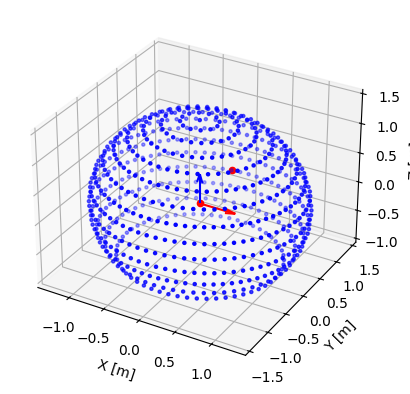

In [62]:
hrtf = slab.HRTF.kemar()
sourceidx = hrtf.cone_sources(0) + hrtf.elevation_sources(0)
hrtf.plot_sources(208) # plot the sources in 3D, highlighting the selected sources

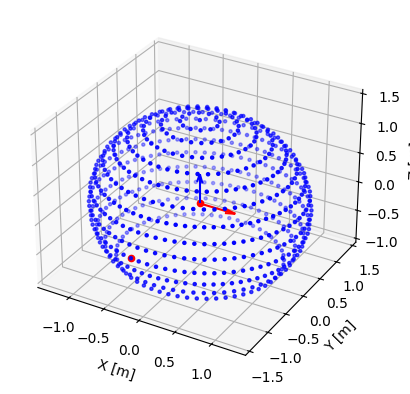

In [65]:
hrtf.plot_sources(240)

In [45]:
hrtf.sources[0].shape

(710, 3)

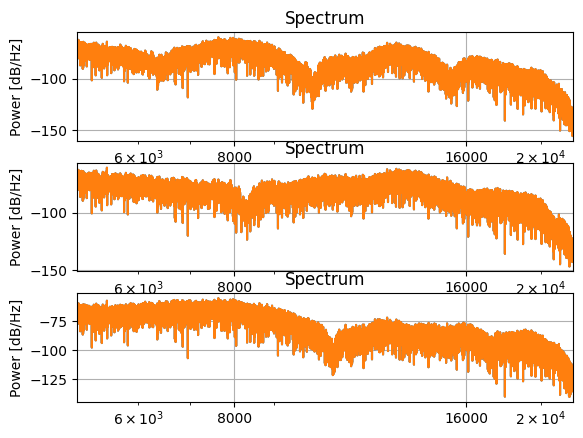

In [8]:
sound = slab.Sound.pinknoise(samplerate=hrtf.samplerate)  # the sound to be spatialized
fig, ax = plt.subplots(3)
sourceidx = [0, 260, 536]  # sources at elevations -40, 0 and 40
spatial_sounds = []
for i, index in enumerate(sourceidx):
    spatial_sounds.append(hrtf.apply(index, sound))
    spatial_sounds[i].spectrum(axis=ax[i], low_cutoff=5000, show=False)
plt.show()

In [15]:
# tone = slab.Sound.tone(frequency=500, duration=0.5)
# tone.level = 80 # setting the intensity to 80 dB
# tone.play()
noise = slab.Sound.pinknoise(duration=0.5)
noise.filter(frequency=(250, 1000), kind='bp') # bandpass .25 to 1 kHz
noise.level = 70 # 10 dB lower than the tone
noise.play()
# stimulus = tone + noise # combine the two signals
# stimulus = stimulus.ramp() # apply on- and offset ramps to avoid clicks
# stimulus.play()

In [22]:
spatial_sounds[0].play()

In [25]:
song_name = "Imagine Dragons - Warriors"
bass = slab.Sound.read(f"./separated/htdemucs/{song_name}/bass.wav")
drums = slab.Sound.read(f"./separated/htdemucs/{song_name}/drums.wav")
other = slab.Sound.read(f"./separated/htdemucs/{song_name}/other.wav")
vocals = slab.Sound.read(f"./separated/htdemucs/{song_name}/vocals.wav")

In [67]:
vocals_left = hrtf.apply(208, vocals)

In [69]:
vocals_left.play() # holy shit oh my god LMAO

KeyboardInterrupt: 

In [68]:
vocals_right = hrtf.apply(240, vocals)

In [72]:
vocals_left_other_right = hrtf.apply(208, vocals) + hrtf.apply(240, other)

In [73]:
vocals_left_other_right.play()

In [29]:
other.play()

KeyboardInterrupt: 

### Music Separation

Install demucs

In [ ]:
# !py -3.11 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

In [23]:
!demucs "../music-library/Imagine Dragons - Warriors.mp3"

Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /Users/yunhocho/Documents/GitHub/musical-intelligence/separated/htdemucs
Separating track ../music-library/Imagine Dragons - Warriors.mp3
100%|████████████████████████████████████████████████████████████████████████| 175.5/175.5 [01:38<00:00,  1.78seconds/s]


### Simplest Possible Architecture

1. Let user choose the (vector) location (= direction) of tracks! (Later, make it draggable!)
2. While waiting for head-tracking info: 
3. Get relative vector from head to each source
4. Determine a small sample window (50ms? 100ms?)
5. Apply HRTF to each track according to vector
6. Sum channels & play!
7. Render visuals too. (have little circular icons for each instrument, I guess)

All I need to do is simple location tracking, so let's just do it myself. 

Keep track of 3D locations (i.e., my **view vector**), I guess the field of view (maybe this part is in Pano -> Plane Image logic), where the sources are in 2D plane space, then just draw them onto screen. Simple enough!

Or, lowkey - rendering part might be easier in Threlte/Three+Vue. 흠 어떡할까!?

Let's make a demo video! Post in portfolio!